In [10]:
# ASCAT wind speed plotter (.nc only) (no directions/vectors plotted)
# Demo uses .nc from EUMETSAT (ASCAT-B) from TS Nadine (2024)

file_path = 'ascat_20241019_030600_metopb_62716_eps_o_coa_3301_ovw.l2.nc'

# Motivation:
# https://www.nhc.noaa.gov/archive/2024/al15/al152024.discus.003.shtml?
# Discussion cites above ASCAT-C pass having 34 kt winds for upgrading AL95 to TS Nadine (2024)
# Must be referencing "Coastal" product, as no 34-kt winds show up in ASCAT C 25 km product
# All 34+ kt winds in swathe fail variational quality control (winds are suspect per KNMI manual)
# NRL and KNMI (Multiplatform viewer) showed coastal winds. Only NESDIS shows 25 km default.
# No color/flag/marker for variational quality control flag on NRL/KNMI plots to notice it is suspect.
# Worse NRL doesn't show barbs, so could not tell it was suspect from the direction.

# There was other support for TS though (ADT, D-PRINT, MTCSWA, weatherflow observation)

In [4]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import numpy as np


def mask_wind_speed(qc, qc_flags, flag_masks, flag_meanings, wind_speed):
    wind_speed_masked = wind_speed.copy()
    # convert the string to a list
    flag_meanings = flag_meanings.split(' ')
    for flag_meaning, flag_mask in zip(flag_meanings, flag_masks):
        if flag_meaning in qc_flags:
            wind_speed_masked[np.where((qc & flag_mask) != 0)] = np.nan
    return wind_speed_masked

def plot_ascat(file_path, metric, lon_min, lon_max, lat_min, lat_max, qc_flags):

    if not metric:
        # Define wind speed ranges in kt
        ranges = [0, 12, 25, 34, 50, 64, 100, 120, 200]
    else:
        # in m/s
        ranges = [0, 6.17, 12.85, 17.42, 25.93, 32.87, 51.44, 61.72, 102.96]

    # Create a PlateCarree projection
    proj = ccrs.PlateCarree()

    # Define custom color map
    colors = [
        (0.47, 0.53, 1),  #  Blue
        (0.5, 0.9, 0.5),  # Light Green
        (1, 0.8, 0),  # Light Yellow
        (1, 0, 0),  # Red
        (0.5, 0, 0.5),  # Purple
        (1, 0.5, 0.7),  # Light Pink
        (0.5, 0.5, 0.5),  # Grey
        (0, 0.5, 0.5),  # Teal
        (0, 0.2, 0.2)  # Dark Teal/Black
    ]

    # Create color map and norm
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(ranges, len(colors))

    fig = plt.figure(figsize=(8, 12))

    # Create a GeoAxes object
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)

    # process data

    nc_file = nc.Dataset(file_path, 'r')

    # Extract wind speed, latitude, and longitude data
    wind_speed = nc_file.variables['wind_speed'][:]
    lats = nc_file.variables['lat'][:]
    lons = nc_file.variables['lon'][:]
    qc = nc_file.variables['wvc_quality_flag'][:]

    # Wrap longitudes to [-180, 180] range
    lons_wrapped = np.where(lons > 180, lons - 360, lons)

    if not metric:
        # Convert wind speed values from m/s to kt
        wind_speed = wind_speed * 1.94384

    # Mask invalid wind speed values
    wind_speed_masked = np.ma.masked_invalid(wind_speed)

    # Mask data where QC is not 0
    #wind_speed_masked = np.where(qc == 0, wind_speed_masked, np.nan)
    # mask according to qc_flags
    wind_speed_masked = mask_wind_speed(qc, qc_flags, 
                                        nc_file.variables['wvc_quality_flag'].flag_masks, 
                                        nc_file.variables['wvc_quality_flag'].flag_meanings, 
                                        wind_speed_masked)

    # Get the time variable
    time_var = nc_file.variables['time']

    # Find the indices of the points within the extent
    lons_wrapped_flat = lons_wrapped.flatten()
    lats_flat = lats.flatten()
    indices = np.where((lons_wrapped_flat >= ax.get_xlim()[0]) & (lons_wrapped_flat <= ax.get_xlim()[1]) & (lats_flat >= ax.get_ylim()[0]) & (lats_flat <= ax.get_ylim()[1]))

    time_flat = time_var[:].flatten()
    time_min = np.min(time_flat[indices])
    time_max = np.max(time_flat[indices])

    # Get the start and end indices for the swath extent
    start_idx = time_min
    end_idx = time_max

    start_date = nc.num2date(time_min, time_var.units)
    end_date = nc.num2date(time_max, time_var.units)

    # Format the dates as strings
    start_date_str = start_date.strftime('%Y-%m-%d %H:%M:%S')
    end_date_str = end_date.strftime('%Y-%m-%d %H:%M:%S')


    im = ax.scatter(lons_wrapped.flatten(), lats.flatten(), c=wind_speed_masked.flatten(), cmap=cmap, norm=norm, transform=proj, s=2)

    cax = fig.add_axes([0.1, 0.1, 0.8, 0.01])

    # Create color bar
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap=cmap, norm=norm),
        cax=cax,
        orientation="horizontal",
        ticks=ranges[:-1],
    )

    cbar.ax.tick_params(axis='x', which='major', pad=5)
    cbar.ax.set_xticklabels(cbar.ax.get_xticks(), ha='center')

    if not metric:
        cbar.set_label('Wind Speed (knots)')
    else:
        cbar.set_label('Wind Speed (m/s)')

    # grid
    ax.grid(which='major', axis='both', linestyle='-', linewidth=0.1, color='gray', alpha=0.8)

    #1 degree grid
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('{:.0f}'))

    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('{:.0f}'))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y)))

    # get the short title of the source data
    short = nc_file.title_short_name
    ax.set_title(f'{short}\nSwathe: {start_date_str} - {end_date_str}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    fig.text(x=1.0, y=0.8, s="QC Flags:\n" + "\n".join(qc_flags), ha='left', va='top', fontsize=12)

    # Show the plot
    plt.show()

In [6]:
metric = False

lon_min = -90
lon_max = -80
lat_min = 14
lat_max = 25

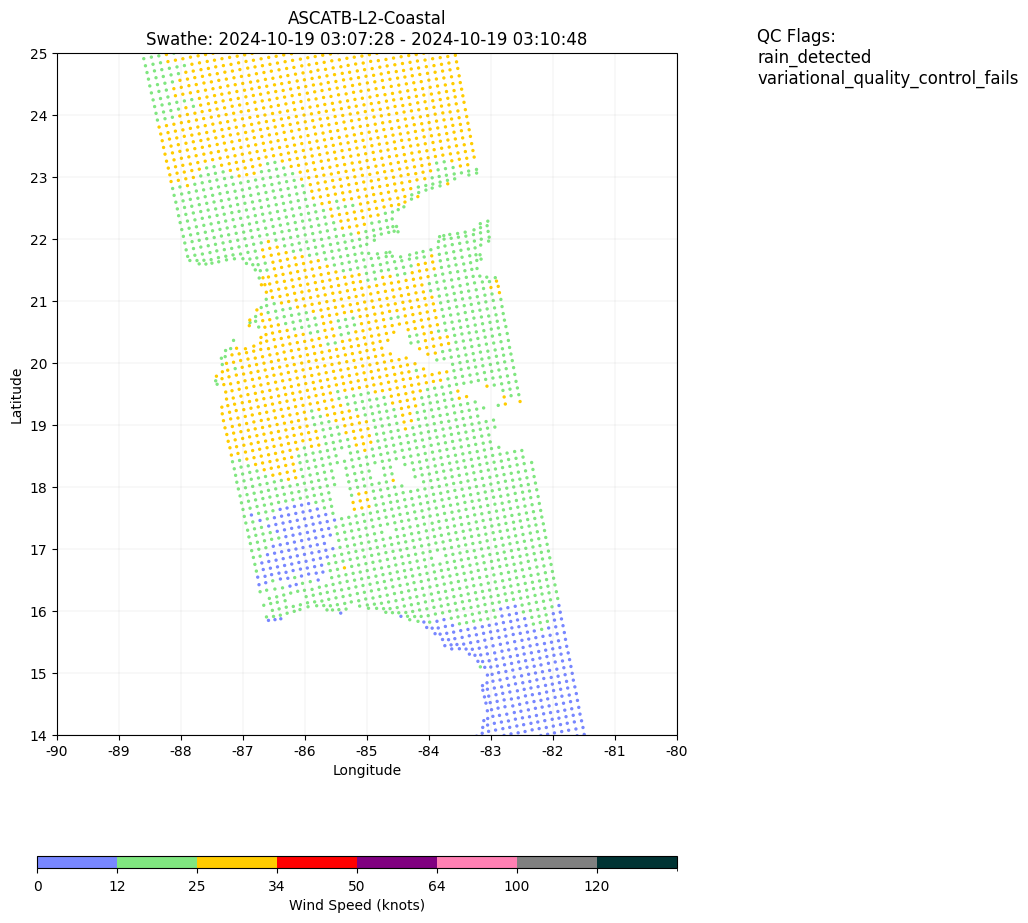

In [7]:
qc_flags = [
    #'distance_to_gmf_too_large',
    #'data_are_redundant',
    #'no_meteorological_background_used',
    'rain_detected',
    #'not_usable_for_visualisation',
    #'small_wind_less_than_or_equal_to_3_m_s',
    #'large_wind_greater_than_30_m_s',
    #'wind_inversion_not_successful',
    #'some_portion_of_wvc_is_over_ice',
    #'some_portion_of_wvc_is_over_land',
    'variational_quality_control_fails',
    #'knmi_quality_control_fails',
    #'product_monitoring_event_flag',
    #'product_monitoring_not_used',
    #'any_beam_noise_content_above_threshold',
    #'poor_azimuth_diversity',
    #'not_enough_good_sigma0_for_wind_retrieval'
]

plot_ascat(file_path, metric, lon_min, lon_max, lat_min, lat_max, qc_flags)

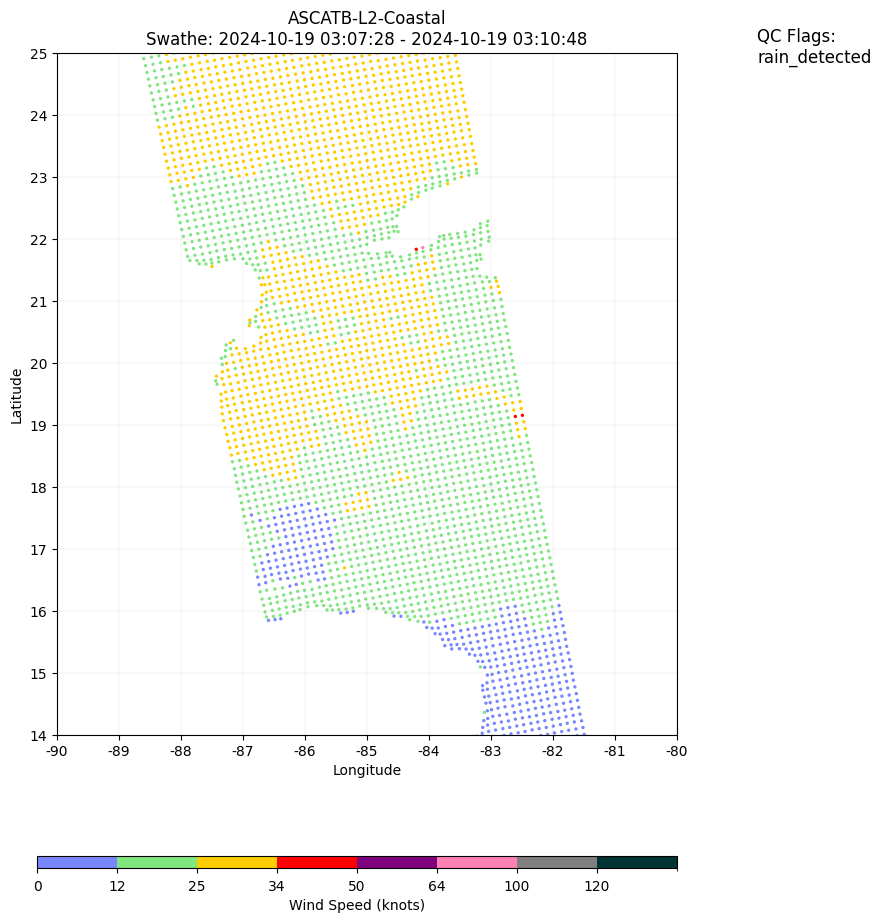

In [8]:
qc_flags = [
    #'distance_to_gmf_too_large',
    #'data_are_redundant',
    #'no_meteorological_background_used',
    'rain_detected',
    #'not_usable_for_visualisation',
    #'small_wind_less_than_or_equal_to_3_m_s',
    #'large_wind_greater_than_30_m_s',
    #'wind_inversion_not_successful',
    #'some_portion_of_wvc_is_over_ice',
    #'some_portion_of_wvc_is_over_land',
    #'variational_quality_control_fails',
    #'knmi_quality_control_fails',
    #'product_monitoring_event_flag',
    #'product_monitoring_not_used',
    #'any_beam_noise_content_above_threshold',
    #'poor_azimuth_diversity',
    #'not_enough_good_sigma0_for_wind_retrieval'
]

plot_ascat(file_path, metric, lon_min, lon_max, lat_min, lat_max, qc_flags)